# Tranform coordinates

In this notebook, coordinates of all federal states are transformed to EPSG 3035 (ETRS89-extended / LAEA Europe).

In [21]:
import os
import re

from pyproj import Transformer
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from camelsp import Bundesland
from camelsp.util import get_metadata, get_full_nuts_mapping

In [2]:
# read metadata
df = pd.read_csv("../output_data/raw_metadata/DED_raw_metadata.csv")
df.columns

Index(['Pegelkennziffer', 'Pegelname', 'Gewaesser', 'unit_q', 'unit_w',
       'OBJECTID', 'MSTNR', 'NAME', 'ART', 'ORDNUNG', 'AE', 'FLUSS_KM',
       'LAGE_GEW', 'LAGE_MDG', 'PNP', 'HOEHENSYS', 'SYSTEM', 'W_SEIT',
       'Q_SEIT', 'EDVW', 'EDVQ', 'AS1', 'AS2', 'AS3', 'AS4', 'OSTWERT',
       'NORDWERT', 'EDVW_BIS', 'EDVQ_BIS', 'GEBKZ', 'GEWAESSER', 'FLUSSGEB',
       'DATENSTAND'],
      dtype='object')

Build a lookup dictionary which contains the source CRS, column names of X and Y coordinates, the name of the area column and the name of the ID column in the raw metadata table.

In [8]:
# build lookup dict
from camelsp.util import _NUTS_LVL2_NAMES

nuts_ids = list(_NUTS_LVL2_NAMES.keys())

# values: CRS, column names location [x, y], column name area, column name ID
_LOCATION_DICT = {
    'DE1': {'epsg': 'EPSG:25832', 'xy': ['Ost (UTM ETRS89)', 'Nord (UTM ETRS89)'], 'area': 'Einzugsgebiet in km²', 'id': 'Messstellennummer'},
    'DE2': {'epsg': 'EPSG:25832', 'xy': ['Ostwert', 'Nordwert'], 'area': 'EZG km²', 'id': 'Stationsnummer'}, 
    'DE4': {'epsg': 'EPSG:32633', 'xy': ['Ost/RW', 'Nord/HW'], 'area': 'CATCHMENT_SIZE', 'id': 'Messstellennummer'},
    'DE7': {'epsg': 'EPSG:25832', 'xy': ['Koordinaten X', 'Koordinaten Y'], 'area': 'Größe des Einzugsge-biets [km²]', 'id': 'Messstellen Nr.'},
    'DE8': {'epsg': 'EPSG:32633', 'xy': ['rechtswert', 'hochwert'], 'area': 'einzugsgebiet', 'id': 'pegelkennzahl'},
    'DE9': {'epsg': 'EPSG:31467', 'xy': ['RECHTS3', 'HOCH3'], 'area': 'SHAPE_STAr', 'id': 'MESSSTELLE_NR'},
    'DEA': {'epsg': 'EPSG:32632', 'xy': ['KOORDX', 'KOORDY'], 'area': 'Einzugsgebiet', 'id': 'Stationsnummer'},
    'DEB': {'epsg': 'EPSG:31466', 'xy': ['RW', 'HW'], 'area': 'Aeo', 'id': 'Nummer'},
    'DEC': {'epsg': 'EPSG:31466', 'xy': ['RW', 'HW'], 'area': 'EZG_Gr', 'id': 'MSTNR'},
    'DED': {'epsg': 'EPSG:32633', 'xy': ['OSTWERT', 'NORDWERT'], 'area': 'AE', 'id': 'Pegelkennziffer'},
    'DEE': [], # no location at all??
    'DEF': {'epsg': 'EPSG:4647', 'xy': ['x', 'y'], 'area': 'area', 'id': 'id'},
    'DEG': {'epsg': 'EPSG:25832', 'xy': ['RW (GK 4)', 'HW (GK 4)'], 'area': 'EZG', 'id': 'Pegelnr'},
}

_LOCATION_DICT

{'DE1': {'epsg': 'EPSG:25832',
  'xy': ['Ost (UTM ETRS89)', 'Nord (UTM ETRS89)'],
  'area': 'Einzugsgebiet in km²',
  'id': 'Messstellennummer'},
 'DE2': {'epsg': 'EPSG:25832',
  'xy': ['Ostwert', 'Nordwert'],
  'area': 'EZG km²',
  'id': 'Stationsnummer'},
 'DE4': {'epsg': 'EPSG:32633',
  'xy': ['Ost/RW', 'Nord/HW'],
  'area': 'CATCHMENT_SIZE',
  'id': 'Messstellennummer'},
 'DE7': {'epsg': 'EPSG:25832',
  'xy': ['Koordinaten X', 'Koordinaten Y'],
  'area': 'Größe des Einzugsge-biets [km²]',
  'id': 'Messstellen Nr.'},
 'DE8': {'epsg': 'EPSG:32633',
  'xy': ['rechtswert', 'hochwert'],
  'area': 'einzugsgebiet',
  'id': 'pegelkennzahl'},
 'DE9': {'epsg': 'EPSG:31467',
  'xy': ['RECHTS3', 'HOCH3'],
  'area': 'SHAPE_STAr',
  'id': 'MESSSTELLE_NR'},
 'DEA': {'epsg': 'EPSG:32632',
  'xy': ['KOORDX', 'KOORDY'],
  'area': 'Einzugsgebiet',
  'id': 'Stationsnummer'},
 'DEB': {'epsg': 'EPSG:31466',
  'xy': ['RW', 'HW'],
  'area': 'Aeo',
  'id': 'Nummer'},
 'DEC': {'epsg': 'EPSG:31466',
  'xy': 

Function that transforms coordinates for a given Bundesland based on the `_LOCATION_DICT`  
& function that plots the processed locations and the locations that have been processed before by opther to see if there are any differences

In [4]:
# create locations directory if it does not exist
os.makedirs("../output_data/locations", exist_ok=True)


def plot_on_germany_map(df_location, df_compare):
    # Get the world map from geopandas datasets
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Extract the boundary for Germany (ISO code 'DEU') and reproject to EPSG:3035
    germany_gdf = world[world['iso_a3'] == 'DEU']
    germany_gdf = germany_gdf.to_crs("EPSG:3035")

    # Create GeoDataFrames for the dataframes using their X and Y coordinates
    df_location_gdf = gpd.GeoDataFrame(
        df_location, geometry=gpd.points_from_xy(df_location.X, df_location.Y), crs="EPSG:3035"
    )

    df_compare_gdf = gpd.GeoDataFrame(
        df_compare, geometry=gpd.points_from_xy(df_compare.X, df_compare.Y), crs="EPSG:3035"
    )

    # Plotting the map of Germany and the dataframes
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot Germany
    germany_gdf.boundary.plot(ax=ax, color="gray", linewidth=1.2)

    # Plot df_compare with blue dots
    df_compare_gdf.plot(ax=ax, color="blue", markersize=50, label="df_compare", zorder=2)

    # Plot df_location with red crosses
    df_location_gdf.plot(ax=ax, color="red", markersize=50, marker="x", label="df_location", zorder=3)

    # Set axis limits to focus on Germany
    ax.set_xlim(4e6, 4.7e6)  # X range of Germany in EPSG:3035
    ax.set_ylim(2.65e6, 3.6e6)  # Y range of Germany in EPSG:3035

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()


def transform_coords(nuts_id: str, location_dict: dict, verbose: bool=True) -> pd.DataFrame:
    if nuts_id not in location_dict.keys():
        raise ValueError(f"[{nuts_id}]: nuts_id {nuts_id} not contained in given location_dict.")
    
    # if location_dict[nuts_id] is empty, no location is available, load the location.csv from CAMELS folder (processed by hand?)
    if not location_dict[nuts_id]:
        df_location = pd.read_csv(f"/home/alexd/bwSyncShare/CAMELS/locations_vgl/{nuts_id}_Locations.csv")
        
        # make copy of df_location, else, a geometry column is added in plot_on_germany_map
        df_location_copy = df_location.copy()
        if verbose:
            plot_on_germany_map(df_location_copy, df_location_copy)

        if verbose:
            # ask user if location should be saved as csv
            input_save = input('Do you want to save df_location as a CSV file? (y/n): ')
        else:
            input_save = 'y'

        # write locations dataframe to folder locations
        if input_save == 'y':
            df_location.to_csv(f"../output_data/locations/{nuts_id}_Locations.csv", index=False)
            print(f"Location for {nuts_id} saved as CSV.") 
            
        print(f"[{nuts_id}]: No location available in raw metadata, using location.csv from CAMELS folder (processed by hand?)")

        return df_location
    
    # read raw metadata file for selected Bundesland
    raw_meta = pd.read_csv(f"../output_data/raw_metadata/{nuts_id}_raw_metadata.csv")

    # get epsg code of source location
    from_epsg = location_dict[nuts_id]['epsg']

    # get necessary columns
    xy_columns = location_dict[nuts_id]['xy']
    area_column = location_dict[nuts_id]['area']
    id_column = location_dict[nuts_id]['id']

    # transformer from source epsg to 3035
    transformer = Transformer.from_crs(from_epsg, "EPSG:3035", always_xy=True)

    x_transformed = []
    y_transformed = []

    # transform coordinates
    for _, row in raw_meta[xy_columns].iterrows():
        x, y = row[0], row[1]

        transformed_coords = transformer.transform(x, y)
        x_transformed.append(transformed_coords[0])
        y_transformed.append(transformed_coords[1])

    # build dataframe
    df_location = pd.DataFrame({'ID': raw_meta[id_column], 'Area': raw_meta[area_column], 'X': x_transformed, 'Y': y_transformed})

    # remove eventually occuring characters from area column (e.g. ' km²') and transform to float
    df_location['Area'] = pd.to_numeric(df_location['Area'].apply(lambda x: re.sub(',', '.', str(x).split(' ')[0].split('km')[0]) if str(x).strip() != 'nan' else np.nan), errors='coerce')

    # compare to already processed locations (by others)
    df_compare = pd.read_csv(f"/home/alexd/bwSyncShare/CAMELS/locations_vgl/{nuts_id}_Locations.csv")
 
    # Set the float format option
    pd.options.display.float_format = '{:.3f}'.format

    # drop possible duplicates
    df_location = df_location.drop_duplicates(subset='ID')

    # sort both dfs by ID column
    df_location = df_location.sort_values(by='ID', ignore_index=True)
    df_compare = df_compare.sort_values(by='ID', ignore_index=True)

    # round dataframes, as precisssions are not necessarily the same
    if round(df_location, 0).equals(round(df_compare, 0)):
        if verbose:
            print(f"{nuts_id}: OK\n")
    else:
        if verbose:
            print(f"{nuts_id}: The produced location file seems to be different from the already produced file (by others)!\n")

    if verbose:
        # print head of both dataframes for visual comparison
        print('df_location:')
        print(df_location)
        print('df_compare')
        print(df_compare)

    # make copy of df_location, else, a geometry column is added in plot_on_germany_map
    df_location_copy = df_location.copy()

    if verbose:
        # plot new and old locations for comparison
        plot_on_germany_map(df_location_copy, df_compare)

    if verbose:
        # ask user if location should be saved as csv
        input_save = input('Do you want to save df_location as a CSV file? (y/n): ')
    else:
        input_save = 'y'

    # write locations dataframe to folder locations
    if input_save == 'y':
        df_location.to_csv(f"../output_data/locations/{nuts_id}_Locations.csv", index=False)
        print(f"Location for {nuts_id} saved as CSV.") 

    return df_location

DED: The produced location file seems to be different from the already produced file (by others)!

df_location:
         ID    Area           X           Y
0    530020  55.700 4496827.441 3029842.481
1    530021     NaN         inf         inf
2    550090     NaN         inf         inf
3    550091  96.800 4623158.938 3099436.567
4    550110 154.000 4615223.343 3098983.140
..      ...     ...         ...         ...
277  663090 166.000 4667286.853 3117599.927
278  663100     NaN         inf         inf
279  663130     NaN         inf         inf
280  663131  13.500 4656075.496 3112222.875
281  664100     NaN         inf         inf

[282 rows x 4 columns]
df_compare
          ID      Area        X        Y
0     501010 51391.000  4618913  3093547
1     501040 52080.000  4596922  3102217
2     501060 53096.000  4583023  3111502
3     501080 53885.000  4564003  3122811
4     501110 54485.000  4550545  3138570
..       ...       ...      ...      ...
305   663090   166.000  4667287  31176

/tmp/ipykernel_7326/1111445202.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


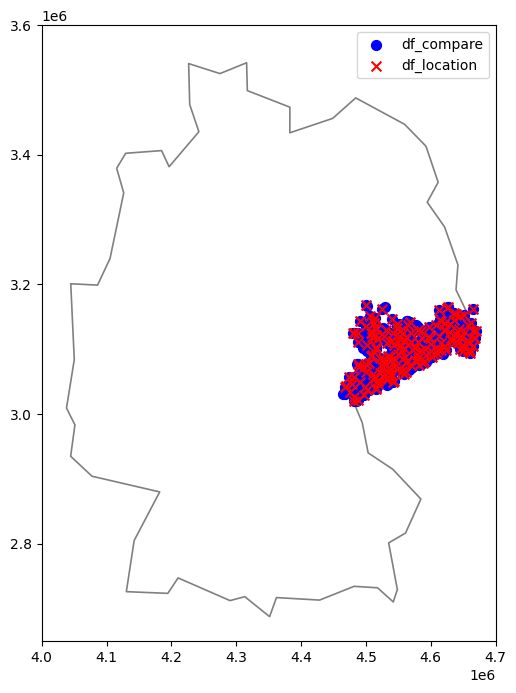

Location for DED saved as CSV.


,ID,Area,X,Y
0,530020,55.700,4496827.441,3029842.481
1,530021,NaN,inf,inf
2,550090,NaN,inf,inf
3,550091,96.800,4623158.938,3099436.567
4,550110,154.000,4615223.343,3098983.140
...,...,...,...,...
277,663090,166.000,4667286.853,3117599.927
278,663100,NaN,inf,inf
279,663130,NaN,inf,inf
280,663131,13.500,4656075.496,3112222.875


In [15]:
transform_coords('DED', _LOCATION_DICT, verbose=True)

In [6]:
# go for all bl, save locations as csv without asking
for nuts_id in _LOCATION_DICT.keys():
    print(f"Processing {nuts_id}...")
    transform_coords(nuts_id=nuts_id, location_dict=_LOCATION_DICT, verbose=False)

Processing DE1...
Location for DE1 saved as CSV.
Processing DE2...
Location for DE2 saved as CSV.
Processing DE4...
Location for DE4 saved as CSV.
Processing DE7...
Location for DE7 saved as CSV.
Processing DE8...
Location for DE8 saved as CSV.
Processing DE9...
Location for DE9 saved as CSV.
[DE9]: No location available in raw metadata, using location.csv from CAMELS folder (processed by hand?)
Processing DEA...
Location for DEA saved as CSV.
Processing DEB...
Location for DEB saved as CSV.
Processing DEC...
Location for DEC saved as CSV.
Processing DED...
Location for DED saved as CSV.
[DED]: No location available in raw metadata, using location.csv from CAMELS folder (processed by hand?)
Processing DEE...
Location for DEE saved as CSV.
[DEE]: No location available in raw metadata, using location.csv from CAMELS folder (processed by hand?)
Processing DEF...
Location for DEF saved as CSV.
Processing DEG...
Location for DEG saved as CSV.
